# Dataset Preprocessing
### Outline of Preprocessing Steps
- Discover and Visualize
	- Inspect
	- Histogram
	- Look for Correlations
	- Boxplot
- Experimenting with Attribute Combinations
- Prepare for Machine Learning Algorithms:
	- Data Cleaning
		- Remove duplicates
		- Fix incorrect data types
		- Standardize column names (optional)
	- Handle Missing Values
	- Handle Text and Categorical Attributes
	- Handle Outliers
	- Feature Scaling
	- Feature Engineering (optional)
	- Dimensionality Reduction
	- Handling Imbalanced Data (for classification)
	- Train-Test Split

#### Discover and Visualize

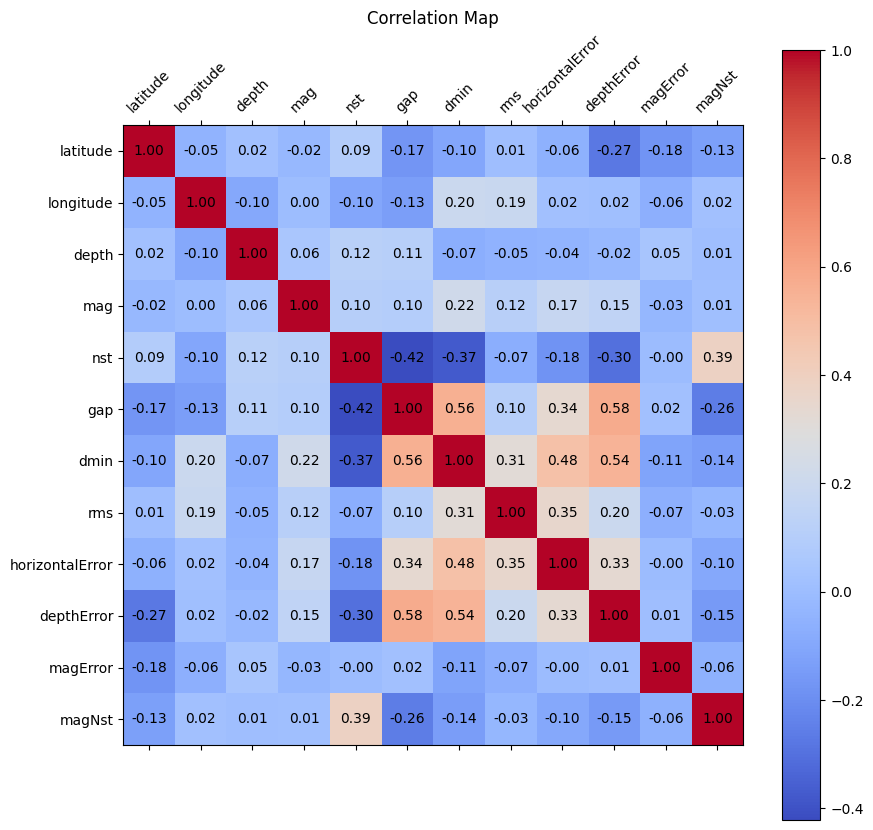

In [2]:
import pandas
import matplotlib.pyplot as plot

# Load dataset
data = pandas.read_csv("all-raw-dataset.csv")

### Inspect dataset
inspect = False

if inspect:
	print( "Total missing values per column/feature:", data.isnull().sum() )

### Visualize dataset
histrogram = False
correlation = True
boxplot = False

# Histogram
if histrogram:
	data.hist( bins = 20, figsize = (20, 15) )
	plot.suptitle( "\nHistograms of Numerical Features:" )

# Correlation Matrix
if correlation:
	corr_matrix = data.corr( numeric_only = True )

	fig, ax = plot.subplots( figsize=(10, 10) )
	cax = ax.matshow( corr_matrix, cmap = "coolwarm" )
	fig.colorbar( cax )

	plot.xticks( range( len( corr_matrix.columns )), corr_matrix.columns, rotation = 45 )
	plot.yticks( range( len( corr_matrix.columns )), corr_matrix.columns )
	for i in range( len( corr_matrix.columns )):
		for j in range( len( corr_matrix.columns )):
			ax.text( j, i, f"{corr_matrix.iloc[ i, j ]:.2f}", va = "center", ha = "center" )
	plot.title( "Correlation Map" )
	plot.show()

# Box plot
if boxplot:
	numeric_cols = list(data.select_dtypes( include = ['int64', 'float64'] ).columns)

	plot.figure( figsize = (10, 10) )
	data.boxplot( column = numeric_cols, vert = True )
	plot.title( "Boxplot of Numerical Features" )
	plot.show()

#### Insights from correlation map:
- gap, nest, and dmin are strongly correlated. More stations (nst) reduce gap and are closer to the event (lower dmin)
- Fewer stations = higher gap and higher distance
- depthError, horizontalError, gap, and dmin are moderately correlated. Poorly covered or distant events lead to higher errors in location and depth.
- mag does not strongly correlate with other features. Magnitude is independent of these parameters, which is scientifically valid since magnitude depends on energy released, not the event's location and geometry.
- Latitude and longtitude have very low correlation with other features.

#### Prepare the Data for Machine Learning

✅ Preprocessing complete. Data saved.


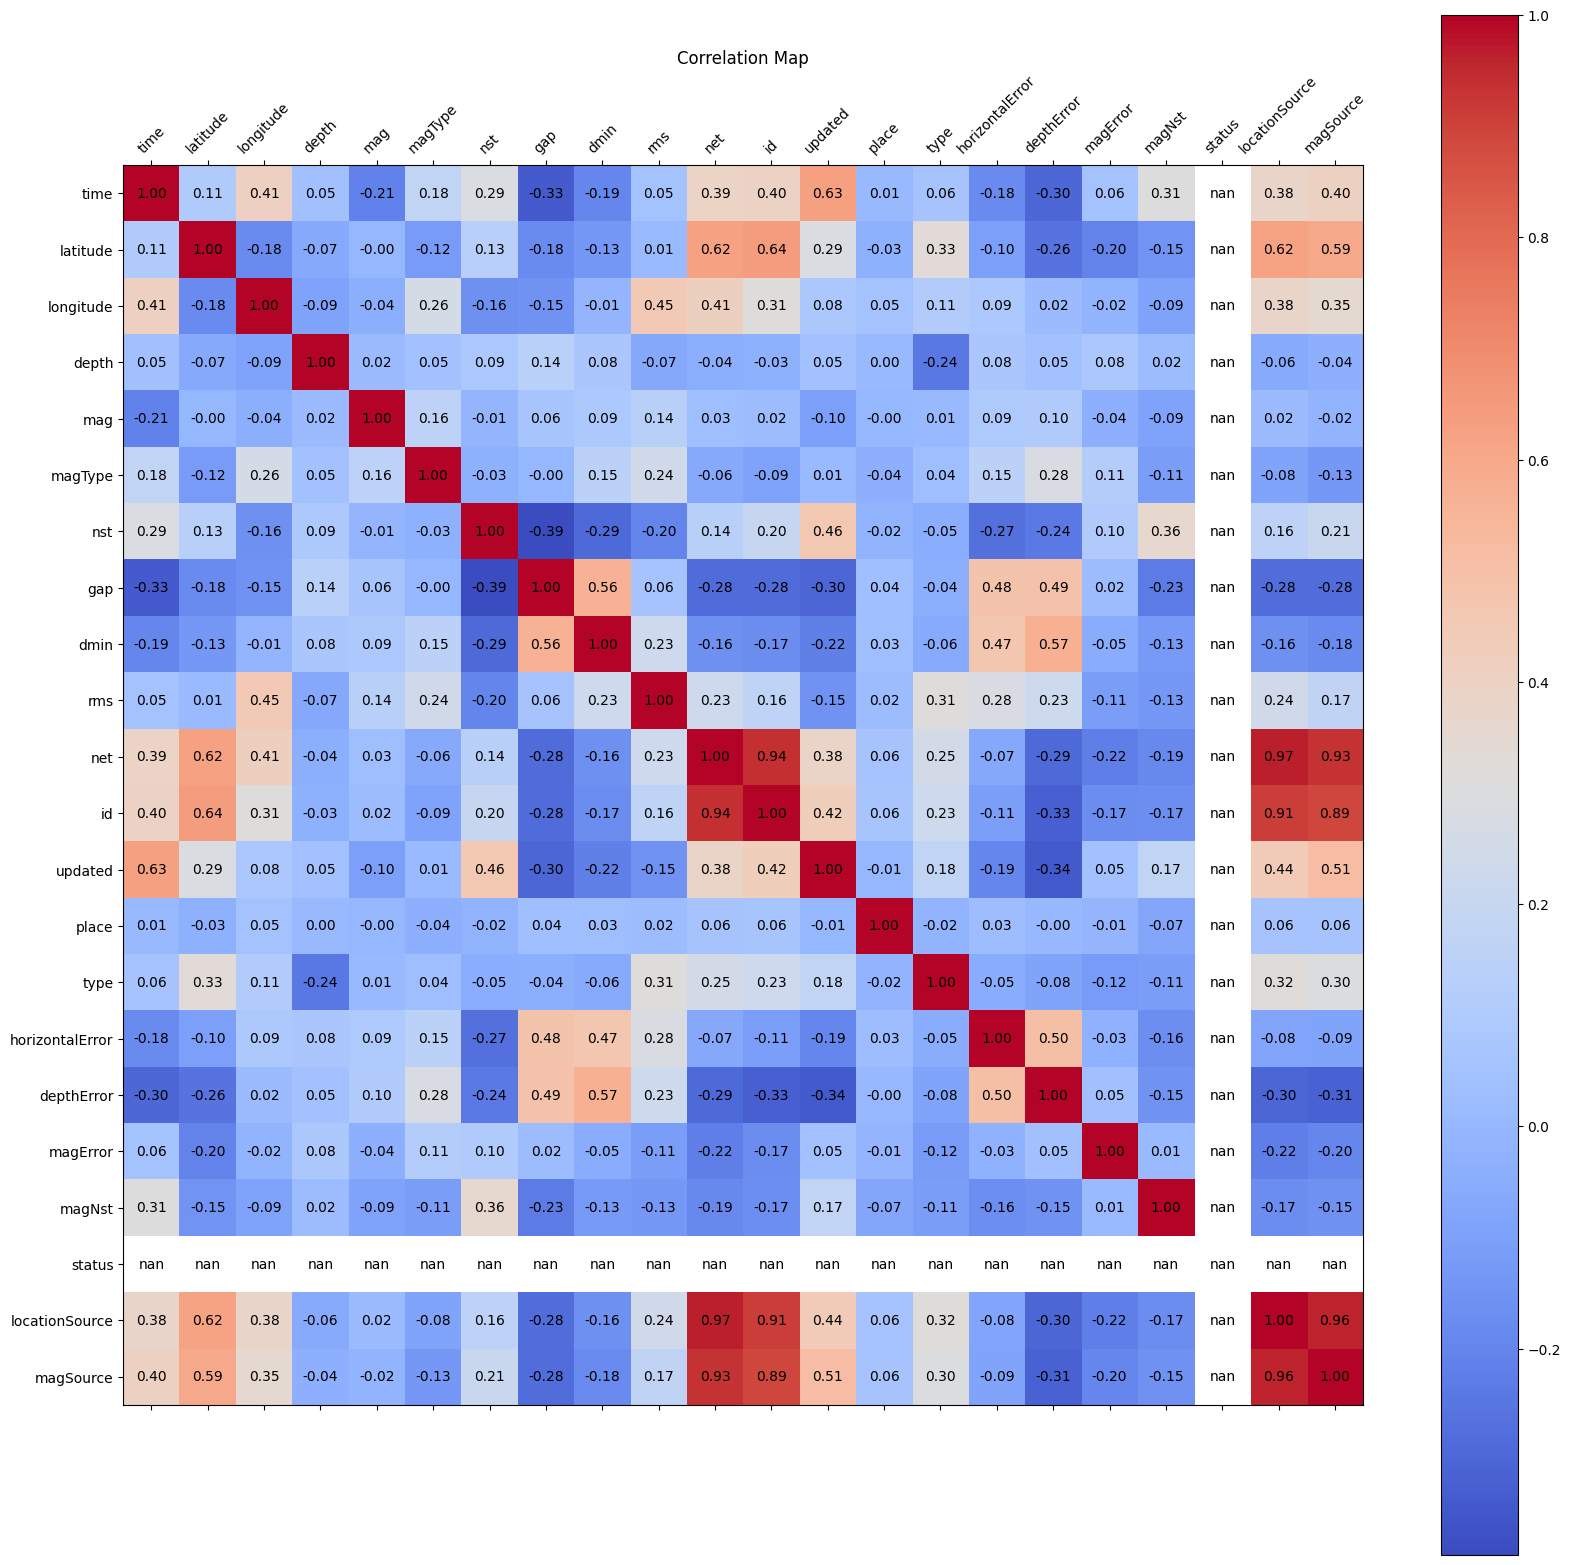

Training data shape: (104976, 13)
Testing data shape: (26245, 13)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Remove duplicates
data = pd.read_csv("all-raw-dataset.csv").drop_duplicates()

# Fix data types
for col in data.select_dtypes( include = ['object'] ).columns:
	try:
		data[ col ] = pd.to_numeric( data[ col ] )
	except ValueError:
		pass	# Keep categorical if cant be converted
	
# Handle missing values
for col in data.columns:
	if data[ col ].isnull().sum() > 0:
		if data[ col ].dtype == "object":
			# If categorical, fill with mode
			data[ col ] = data[ col ].fillna( data[ col ].mode()[0] )
		else:
			# If numerical, fill with median
			data[ col ] = data[ col ].fillna( data[ col ].median())

# Handle categorical features
for col in data.select_dtypes( include = ['object'] ).columns:
	labEnc = LabelEncoder()
	data[ col ] = labEnc.fit_transform( data[ col ] )
	
# Handle outliers using Z-Score
numeric_cols = data.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(data[numeric_cols]))
data = data[(z_scores < 3).all(axis=1)]  # Keep rows with all Z-scores < 3

# Encode categorical features
for col in data.select_dtypes(include=['object']).columns:
    labEnc = LabelEncoder()
    data.loc[:, col] = labEnc.fit_transform(data[col])

# Feature scaling (Exclude Targets from Scaling)
target_variables = ["latitude", "longitude", "mag"]  # Predict 
feature_columns = [col for col in numeric_cols if col not in target_variables]

scaler = StandardScaler()
data[feature_columns] = scaler.fit_transform(data[feature_columns].astype('float64'))

# Define Features (X) and Multi-Output Targets (y)
X = data[feature_columns]  # Features
y = data[target_variables]  # Multi-output target (latitude, longitude, mag)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA (ONLY on training data, NOT targets)
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # Apply same PCA transformation on test data

# Convert back to DataFrame
X_train = pd.DataFrame(X_train_pca)
X_test = pd.DataFrame(X_test_pca)

# Save preprocessed data
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("✅ Preprocessing complete. Data saved.")

histogram = False

correlation = True
boxplot = False

# Histogram
if histogram:
    data.hist(bins=20, figsize=(15, 10))
    plt.suptitle("Histograms of Numerical Features")
    plt.show()

# Correlation Matrix
if correlation:
	corr_matrix = data.corr( numeric_only = True )

	fig, ax = plot.subplots( figsize=(20, 20) )
	cax = ax.matshow( corr_matrix, cmap = "coolwarm" )
	fig.colorbar( cax )

	plot.xticks( range( len( corr_matrix.columns )), corr_matrix.columns, rotation = 45 )
	plot.yticks( range( len( corr_matrix.columns )), corr_matrix.columns )
	for i in range( len( corr_matrix.columns )):
		for j in range( len( corr_matrix.columns )):
			ax.text( j, i, f"{corr_matrix.iloc[ i, j ]:.2f}", va = "center", ha = "center" )
	plot.title( "Correlation Map" )
	plot.show()
    

# Box plot (With Rotation for Readability)
if boxplot:
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    plt.figure(figsize=(12, 8))
    data[numeric_cols].boxplot(rot=45)  # Rotate labels for clarity
    plt.title("Boxplot of Numerical Features")
    plt.show()

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)